# Assignment 5, by Maksim Kaledin

This is a jupyter part of the report.

## Problem 7

First let us formulate the dual problem:

$$\begin{split}
& \max_\lambda \inf_x \left( 2x_1^2+2x_2^2-x_1x_2 +\lambda_1 (1-2x_1-3x_2)+\lambda_2(1-5x_1-4x_2)\right)\\
& s.t. \lambda \geq 0
\end{split}.$$

KKT conditions for the primal problem are

* (stationarity conditions) $\nabla_x L(x,\lambda)=0$
$$
\begin{split}
    &4x_1-x_2-2\lambda_1-5\lambda_2=0,\\
    &4x_2-x_1-3\lambda_1-4\lambda_2=0;
\end{split}
$$
* (feasibility conditions), these are constraints from initial primal problem;
* (complementary slackness conditions)
$$
\begin{split}
    &\lambda_1(1-2x_1-3x_2)=0,\\
    &\lambda_2(1-5x_1-4x_2)=0.
\end{split}
$$

In order to put the dual problem into CVX we also need to reformulate it to optimize a convex function:

$$\begin{split}
& \min_\lambda -\max_x \left[ -\left( 2x_1^2+2x_2^2-x_1x_2 +\lambda_1 (1-2x_1-3x_2)+\lambda_2(1-5x_1-4x_2)\right)\right]\\
& s.t. \lambda \geq 0
\end{split}.$$

## Problem 1

To handle censored data we can exploit the known information about lower bound: let us demand that predicted values for censored observations are bounded from below with $D$. The corresponding optimization problem is
$$
\begin{split}
&\min_{c^T} \sum_{i=1}^{M} (c^Tx_i-y_i)^2,\\
&s.t. \quad c^Tx_i>D \quad \text{for $i>M$},
\end{split}
$$
where $M$ is amount of known $y_i$, $x_i$ are input data vectors. 

In [13]:
import numpy as np #necessary imports
import cvxpy as cv
import matplotlib.pyplot as plt
%matplotlib inline

In [30]:
#Data generation
n=1
M=25
K=100

np.random.seed(1)
c_true = np.random.randn(n)
X=np.random.randn(n,K)
y=np.dot(X.T, c_true)+0.1*np.sqrt(n)*np.random.randn(K)
print(c_true.shape)

#Reorder
sort_ind=np.argsort(y)
X=X[:, sort_ind]
y=y[sort_ind[:(M+1)]]
D=(y[M-1]+y[M])/2
y=y[:M]

(1,)


In [31]:
c_hat = cv.Variable(X.shape[0])

censSq_constr = [X[:,M:].T*c_hat >= D*np.ones((K-M,1))]
censSq_problem = cv.Problem(cv.Minimize(cv.norm(X[:,:M].T*c_hat-y)**2),censSq_constr)

censSq_problem.solve()

print(censSq_problem.status)
print(censSq_problem.value)
print(c_hat.value)

optimal
0.9986395694109287
1.46892881929


We calculated some coefficients, let us check the relative errors and compare it with usual least squares. Compute $c_{ls}$ first.

In [32]:
c_hat_ls = cv.Variable(X.shape[0])

#no constraints
censSq_ls_problem = cv.Problem(cv.Minimize(cv.norm(X[:,:M].T*c_hat_ls-y)**2),[])

censSq_ls_problem.solve()

print(censSq_ls_problem.status)
print(censSq_ls_problem.value)
print(c_hat_ls.value)

optimal
0.1847662623565624
1.62799999169


Check relative errors.

In [34]:
print(np.linalg.norm(c_hat.value-c_true,2)/np.linalg.norm(c_true,2))
print(np.linalg.norm(c_hat_ls.value-c_true,2)/np.linalg.norm(c_true,2))

0.0956794951707
0.00224990824401


In [ ]:
f, ax = plt.subplots(figsize=(5,5))

axp.sca()

## Problem 2

Denote by $t_i$ the travel time on a segment $i$, $i\in{0,..,n}$ ($t$ is a vector of $t_i$), let $n+1$ be a number of waypoints enumareted from $0$, $d_i$ be the length of $i$-th segment, $s_{min}^i,s_{max}^i$ and $T^{i}_{min},T^i_{max}$ be the speed and schedule constraints described in the problem. The corresponding optimization problem is

$$
\begin{split}
&\min_{t} \sum_{i=0}^n \Phi\left( \frac{d_i}{t_i}\right),\\
& s.t. \quad \forall i \quad {t_i} \geq \frac{d_i}{s_{max}^i},~ {t_i} \leq \frac{d_i}{s_{min}^i},\\
& \quad \forall i \sum_{j=0}^i t_j \leq T_{max}^i, ~ \sum_{j=0}^i t_j \geq T_{min}^i,\\
& \quad \forall i ~ t_i \geq 0.
\end{split}
$$

In [36]:
import numpy as np #necessary imports
import cvxpy as cv
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio 

In [91]:


mat_contents = sio.loadmat('veh_sched_data.mat')

a = mat_contents['a'][0,0]
b = mat_contents['b'][0,0]
c = mat_contents['c'][0,0]
d = mat_contents['d'].squeeze()
n = mat_contents['n'][0,0]
s_min = mat_contents['smin'].squeeze()
s_max = mat_contents['smax'].squeeze()
tau_min = mat_contents['tau_min'].squeeze()
tau_max = mat_contents['tau_max'].squeeze()
print(tau_min.shape)
print(n)
print(d.shape)

(100,)
100
(100,)


In [98]:
ts = cv.Variable(tau_min.shape[0])

#t2 = 
d1 = 1/d


veh_obj = cv.Minimize(a*cv.sum_squares(cv.inv_pos(d1*ts))+b*cv.sum_entries(cv.inv_pos(d1*ts))+n*c)
A=np.ones((n,n))
rows,cols = np.indices(A.shape)
A[cols-rows>0]=0
veh_constr = [ts<=d/s_min, ts >= d/s_max, A*ts <= tau_max, A*ts >= tau_min ]

veh_problem = cv.Problem(veh_obj,veh_constr)

veh_problem.solve()

print(veh_problem.status)

optimal


C:\Programs\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: RuntimeWarning: overflow encountered in ubyte_scalars


(100, 1)
(1, 100)


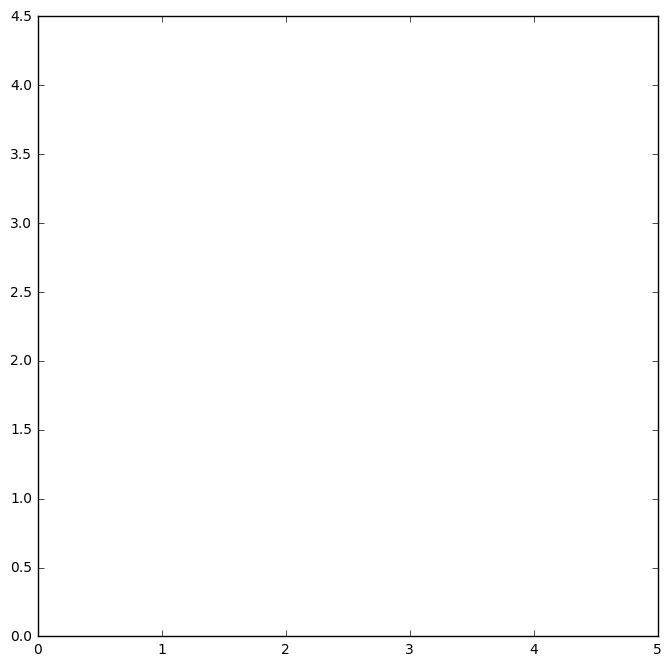

In [113]:
print(ts.value.shape)
plt.figure(figsize=(8,8))
times = ts.value
times=times.reshape(n)
print((times/d).shape)
plt.step(times,times/d)

#plt.plot(states[:-1], smin, linestyle='--',linewidth=1.5, drawstyle='steps')
#plt.plot(states[:-1], smax, linestyle='--',linewidth=1.5, drawstyle='steps')
#plt.title('Velocity at different waypoints')
#plt.xlabel('"Stopping" times')
#plt.ylabel('Velocity')